## 爬蟲專案報告：不動產實價登錄爬蟲 101Q4-108Q4 以六都為例

In [1]:
#匯入套件
import requests
import os
import zipfile
import time
import pandas as pd
import numpy as np

In [2]:
#設定DataFrame顯示方式
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format',lambda x : '%.3f' % x)

In [3]:
#設定不動產實價登陸爬蟲程式
def real_estate_crawler(year, season):
    if year > 1000:
        year -= 1911
    res = requests.get("https://plvr.land.moi.gov.tw//DownloadSeason?season="+str(year)+"S"+str(season)+"&type=zip&fileName=lvr_landcsv.zip")
    fname = str(year)+str(season)+'.zip'
    open(fname, 'wb').write(res.content)
    folder = 'real_estate' + str(year) + str(season)
    if not os.path.isdir(folder):
        os.mkdir(folder)
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall(folder)
    time.sleep(10)

In [5]:
#開始爬蟲 因不動產實價登陸在2013Q4開始有完整資料，故從這個時間點開始爬蟲
real_estate_crawler(101, 4)

for year in range(102, 109):
    for season in range(1,5):
        print(year, season)
        real_estate_crawler(year, season)



102 1
102 2
102 3
102 4
103 1
103 2
103 3
103 4
104 1
104 2
104 3
104 4
105 1
105 2
105 3
105 4
106 1
106 2
106 3
106 4
107 1
107 2
107 3
107 4
108 1
108 2
108 3
108 4


## 匯入爬到的資料夾 並抓取裡面的資料成為DataFrame(以六都的資料為例)

In [6]:
import os
import pandas as pd

# 歷年資料夾
dirs = [d for d in os.listdir() if d[:4] == 'real']

##篩選六都
dfs = []

#台北
for d in dirs:
#    print(d)
    df = pd.read_csv(os.path.join(d,'a_lvr_land_a.csv'), index_col=False)
    df['Q'] = d[-1]
    dfs.append(df.iloc[1:])
#台中
for d in dirs:
#    print(d)
    df = pd.read_csv(os.path.join(d,'b_lvr_land_a.csv'), index_col=False)
    df['Q'] = d[-1]
    dfs.append(df.iloc[1:])
#台南
for d in dirs:
#    print(d)
    df = pd.read_csv(os.path.join(d,'d_lvr_land_a.csv'), index_col=False)
    df['Q'] = d[-1]
    dfs.append(df.iloc[1:])
#新北
for d in dirs:
#    print(d)
    df = pd.read_csv(os.path.join(d,'f_lvr_land_a.csv'), index_col=False)
    df['Q'] = d[-1]
    dfs.append(df.iloc[1:])
#桃園
for d in dirs:
#    print(d)
    df = pd.read_csv(os.path.join(d,'h_lvr_land_a.csv'), index_col=False)
    df['Q'] = d[-1]
    dfs.append(df.iloc[1:])
#高雄
for d in dirs:
#    print(d)
    df = pd.read_csv(os.path.join(d,'e_lvr_land_a.csv'), index_col=False)
    df['Q'] = d[-1]
    dfs.append(df.iloc[1:])
    
df = pd.concat(dfs, sort=True)

## EDA & 資料清理

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698746 entries, 1 to 9145
Data columns (total 29 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Q             object
 1   主要建材          object
 2   主要用途          object
 3   交易年月日         object
 4   交易標的          object
 5   交易筆棟數         object
 6   備註            object
 7   單價元平方公尺       object
 8   土地區段位置建物區段門牌  object
 9   土地移轉總面積平方公尺   object
 10  建物型態          object
 11  建物現況格局-廳      object
 12  建物現況格局-房      object
 13  建物現況格局-衛      object
 14  建物現況格局-隔間     object
 15  建物移轉總面積平方公尺   object
 16  建築完成年月        object
 17  有無管理組織        object
 18  移轉層次          object
 19  編號            object
 20  總價元           object
 21  總樓層數          object
 22  車位移轉總面積平方公尺   object
 23  車位總價元         object
 24  車位類別          object
 25  都市土地使用分區      object
 26  鄉鎮市區          object
 27  非都市土地使用分區     object
 28  非都市土地使用編定     object
dtypes: object(29)
memory usage: 388.8+ MB


In [8]:
##新增欄位，交易年份、單價元坪、縣市別等，並轉換部分欄位型態(原始的欄位都為字串)
# 新增交易年份
df['year'] = df['交易年月日'].str[:-4].astype(int) + 1911

# 不同名稱同項目資料合併
df['單價元平方公尺'].fillna(0)
# 平方公尺換成坪
df['單價元平方公尺'] = df['單價元平方公尺'].astype(float)
df['單價元坪'] = df['單價元平方公尺'] * 3.30579

# 建物型態
df['建物型態2'] = df['建物型態'].str.split('(').str[0]

# 刪除有備註之交易（多為親友交易、價格不正常之交易）
df = df[df['備註'].isnull()]

#劃分出縣市別
df['縣市別']=df['土地區段位置建物區段門牌'].str.slice(0,3)
# 將index改成年月日
df.index = pd.to_datetime((df['交易年月日'].str[:-4].astype(int) + 1911).astype(str) + df['交易年月日'].str[-4:] ,errors='coerce')
#刪除單價元平方公尺為 0的資料 (需要驗證這樣的方式是不是可行)
#df.dropna(subset=['單價元平方公尺'])

In [9]:
df['總價元']=df['總價元'].astype(float)
df['建物現況格局-廳']=df['建物現況格局-廳'].astype(float)

In [10]:
df['縣市別'].value_counts()

新北市    249772
臺中市    193191
高雄市    180729
桃園市    130264
臺南市     91598
桃園縣     81016
臺北市     75864
台中市     36361
台北市     20118
台南市     16630
東勢段      1624
竹圍段      1412
沙崙段      1391
中興段      1037
埔心段       901
中山段       834
仁美段       770
霧峰段       753
新興段       743
頭汴坑       735
和平段       711
復興段       709
三座屋       707
南勢坑       674
成功段       662
溪洲段       657
仁愛段       641
三層段       632
銅鑼圈       621
中正段       612
橫山段       611
歸仁北       574
坑子口       541
大寮段       535
三民段       530
山子頂       526
小八里       510
大同段       509
南勢埔       507
忠孝段       507
埤子頭       506
月眉段       504
大灣段       501
福德段       497
新埔段       465
銀聯段       464
埔子段       460
金城段       458
菁埔段       449
大茅埔       449
五塊厝       449
下圭柔       448
大八里       443
工業區       433
赤崁段       428
忠福段       424
永安段       423
同榮段       423
保安段       421
雙嶺段       420
普義段       417
大湖段       413
下田心       410
北勢坑       408
興南段       408
文化段       407
育仁段       407
新庄段       406
後興段       406
水底寮       404
中央段       392
崙子頂   

In [11]:
#規類縣市群組，因DataFrame縣市別欄位很髒，故需要先清理資料 
df['縣市群組'] = np.select(
    [
        df['縣市別'].isin(['台北市','臺北市']), 
        df['縣市別'].isin(['台中市','臺中市','台中縣','臺中縣']),
        df['縣市別'].isin(['臺南市','台南市','台南縣','臺南縣']),
        df['縣市別'].isin(['桃園市','桃園縣']),
        df['縣市別'].isin(['高雄市','高雄縣']),
        df['縣市別'].isin(['台北縣','臺北縣','新北市']),
        
    ], 
    [
        '台北', 
        '台中',
        '台南',
        '桃園',
        '高雄',
        '新北'
        
        
    ], 
    default='Unknown'
)

In [12]:
#僅篩選六都
df= df.loc[(df['縣市群組']=='台北')|(df['縣市群組']=='新北')|(df['縣市群組']=='台南')|(df['縣市群組']=='高雄')|(df['縣市群組']=='台中')|(df['縣市群組']=='桃園')]

In [13]:
#清理完的六都群組資料筆數
df['縣市群組'].value_counts()

新北    249772
台中    229552
桃園    211280
高雄    180729
台南    108228
台北     95982
Name: 縣市群組, dtype: int64

In [15]:
df.head()

,Q,主要建材,主要用途,交易年月日,交易標的,交易筆棟數,備註,單價元平方公尺,土地區段位置建物區段門牌,土地移轉總面積平方公尺,建物型態,建物現況格局-廳,建物現況格局-房,建物現況格局-衛,建物現況格局-隔間,建物移轉總面積平方公尺,建築完成年月,有無管理組織,移轉層次,編號,總價元,總樓層數,車位移轉總面積平方公尺,車位總價元,車位類別,都市土地使用分區,鄉鎮市區,非都市土地使用分區,非都市土地使用編定,year,單價元坪,建物型態2,縣市別,縣市群組
交易年月日,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-06-29,4,鋼筋混凝土造,國民住宅,1010629,房地(土地+建物),土地1建物2車位0,NaN,184999.000,台北市大安區和平東路三段1巷72弄1~30號,19.39,住宅大樓(11層含以上有電梯),2,3,1,有,100.97999999999999,0740522,有,五層,RPQNMLSJQHHFFFA08CA,18680000.000,十七層,0.0,0,NaN,住,大安區,NaN,NaN,2012,611567.844,住宅大樓,台北市,台北
2012-07-18,4,鋼筋混凝土造,商業用,1010718,房地(土地+建物),土地3建物1車位0,NaN,217307.000,台北市中正區忠孝東路二段121~150號,8.46,辦公商業大樓,0,0,0,有,93.42,0710408,有,九層,RPQOMLKLQHHFFBA17CA,20300000.000,十二層,0.0,0,NaN,商,中正區,NaN,NaN,2012,718371.308,辦公商業大樓,台北市,台北
2012-07-10,4,鋼筋混凝土造,商業用,1010710,房地(土地+建物),土地4建物1車位0,NaN,114317.000,台北市大同區重慶北路一段61~90號,3.88,住宅大樓(11層含以上有電梯),1,1,1,有,36.74,0651207,有,六層,RPOPMLRKJHIFFBA07CA,4200000.000,十一層,0.0,0,NaN,商,大同區,NaN,NaN,2012,377907.995,住宅大樓,台北市,台北
2012-07-10,4,鋼筋混凝土造,住家用,1010710,房地(土地+建物),土地1建物1車位0,NaN,134473.000,台北市內湖區民權東路六段90巷6弄1~30號,32.41,公寓(5樓含以下無電梯),1,3,1,有,104.11,0691114,無,三層,RPPPMLPKQHHFFCA67CA,14000000.000,五層,0.0,0,NaN,住,內湖區,NaN,NaN,2012,444539.499,公寓,台北市,台北
2012-07-17,4,鋼筋混凝土造,國民住宅,1010717,房地(土地+建物),土地1建物1車位0,NaN,175917.000,台北市松山區三民路68巷1~30號,35.53,華廈(10層含以下有電梯),2,3,2,有,146.66,0810303,有,七層,RPOQMLPJKHIFFDA27DA,25800000.000,七層,0.0,0,NaN,住,松山區,NaN,NaN,2012,581544.659,華廈,台北市,台北


In [14]:
#檢視清理完後欄位狀況
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1075543 entries, 2012-06-29 to 2019-10-31
Data columns (total 34 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Q             1075543 non-null  object 
 1   主要建材          1060252 non-null  object 
 2   主要用途          1031618 non-null  object 
 3   交易年月日         1075543 non-null  object 
 4   交易標的          1075543 non-null  object 
 5   交易筆棟數         1075543 non-null  object 
 6   備註            0 non-null        object 
 7   單價元平方公尺       1043196 non-null  float64
 8   土地區段位置建物區段門牌  1075543 non-null  object 
 9   土地移轉總面積平方公尺   1075543 non-null  object 
 10  建物型態          1075543 non-null  object 
 11  建物現況格局-廳      1075543 non-null  float64
 12  建物現況格局-房      1075543 non-null  object 
 13  建物現況格局-衛      1075543 non-null  object 
 14  建物現況格局-隔間     1075543 non-null  object 
 15  建物移轉總面積平方公尺   1075543 non-null  object 
 16  建築完成年月        1044374 non-null  object 
 17  有無管理組織      

## 資料視覺化

### 檢視六都房價走勢

Populating the interactive namespace from numpy and matplotlib


C:\Users\Owen\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['cond', 'plot']
`%matplotlib` prevents importing * from pylab and numpy



<Figure size 2160x720 with 0 Axes>

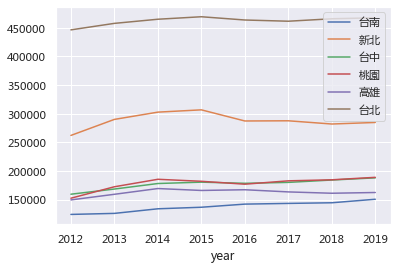

In [32]:
import seaborn as sns
%pylab inline

#支援中文字顯示
#可以去matplotlib設定檔中，找設定參數(參照上面的路徑)
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'  #用來正常顯示中文標籤，微軟雅黑體，['SimHei']
plt.rcParams['axes.unicode_minus'] = False #解決座標軸負數的負號顯示問題
plt.figure(figsize=(30,10))

prices = {}
for district in set(df['縣市群組']):
    cond = (
        (df['主要用途'] == '住家用')
        & (df['縣市群組'] == district)
        & (df['單價元坪'] < df["單價元坪"].quantile(0.95))
        & (df['單價元坪'] > df["單價元坪"].quantile(0.05))
        )
    
    groups = df[cond]['year']
    
    prices[district] = df[cond]['單價元坪'].astype(float).groupby(groups).mean().loc[2012:]
    
price_history = pd.DataFrame(prices)

price_history.plot()
plt.savefig('D:\20201209_1.PNG')

In [18]:
#查看各城市的平均房價
df.groupby(by='縣市群組').mean()['總價元'].sort_values(ascending=False)

縣市群組
台北   27920224.513
新北   13369986.252
台中   10461881.424
桃園    9008597.732
高雄    8389655.216
台南    7464235.293
Name: 總價元, dtype: float64

In [19]:
#平均樓層價格
floor_avg_price = df.groupby(by='總樓層數').mean()['總價元']
floor_avg_price = floor_avg_price.reset_index()

In [20]:
floor_avg_price

,總樓層數,總價元
0,(空白),8865000.000
1,000,46021744.898
2,099,2500000.000
3,z,8000000.000
4,一層,22371059.771
5,七層,9448662.515
6,三十一層,32233130.585
7,三十七層,30260322.149
8,三十三層,23820441.970
9,三十九層,50412783.349


In [21]:
df['總樓層數'].value_counts()

十五層        122503
四層         117676
五層         100850
十四層         93981
十二層         81177
七層          58107
三層          56642
十三層         51160
二層          50933
十一層         30891
十層          29708
八層          26388
九層          24347
十九層         22995
十六層         19427
六層          19021
二十四層        15314
十八層         15227
十七層         14384
二十一層        14032
二十二層        12717
二十層         12461
二十三層        12235
二十六層         8748
二十九層         8694
一層           8349
二十五層         7739
二十八層         7223
二十七層         7168
三十二層         1284
三十五層         1277
三十三層          915
三十六層          781
四十一層          732
三十一層          703
三十八層          671
三十九層          608
三十七層          605
三十四層          605
三十層           578
八十五層          288
四十二層          218
四十層           191
見其他登記事項       165
四十三層          123
000            49
四十六層           21
五十層            17
見使用執照          13
(空白)            8
地下層             4
099             2
z               1
Name: 總樓層數, dtype: int64

### 檢視不同樓層數總價元

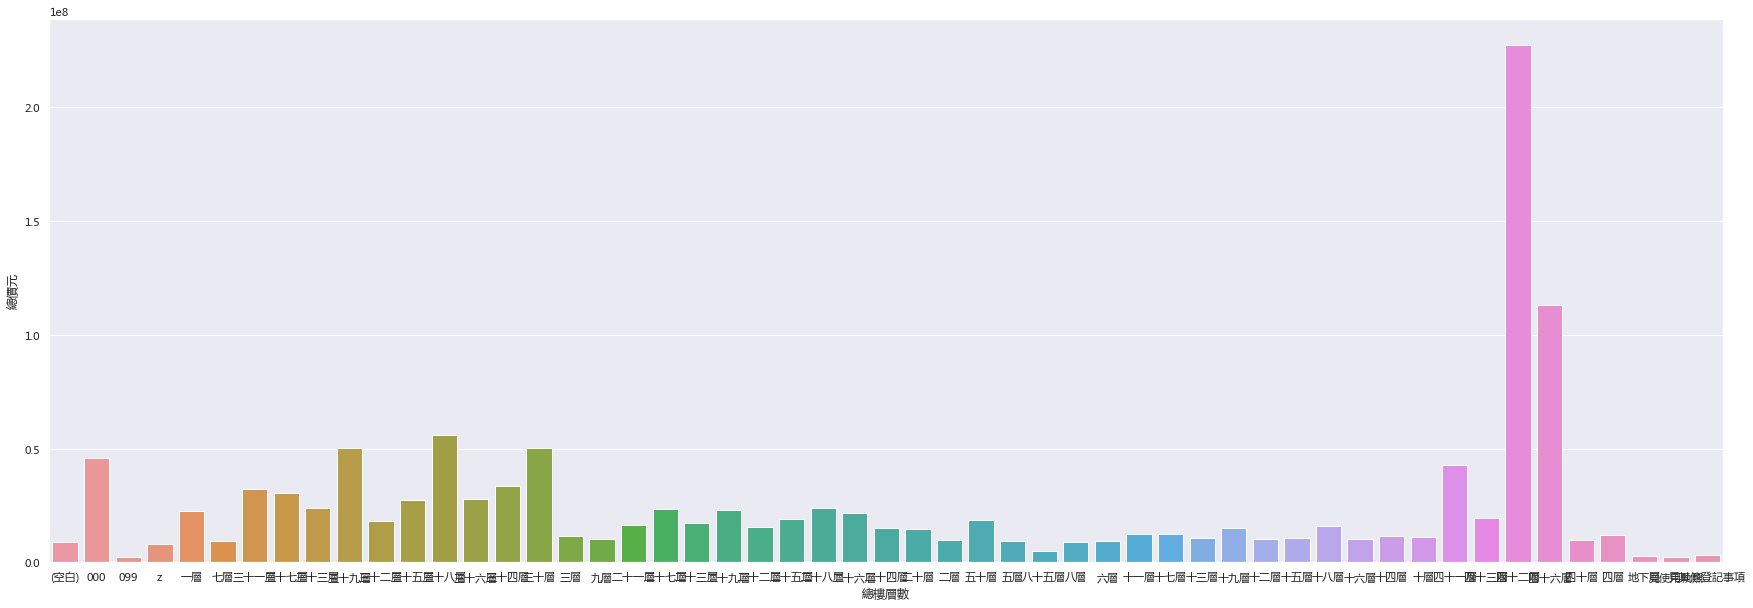

In [33]:
plt.figure(figsize=(30,10))
plt.rcParams['font.size'] = 5
plt.xlabel('總樓層')
plt.ylabel("平均價格")
sns.barplot(x="總樓層數", y="總價元", data=floor_avg_price)
plt.savefig('D:\20201209_2.PNG')

### 檢視六都單坪價格分布

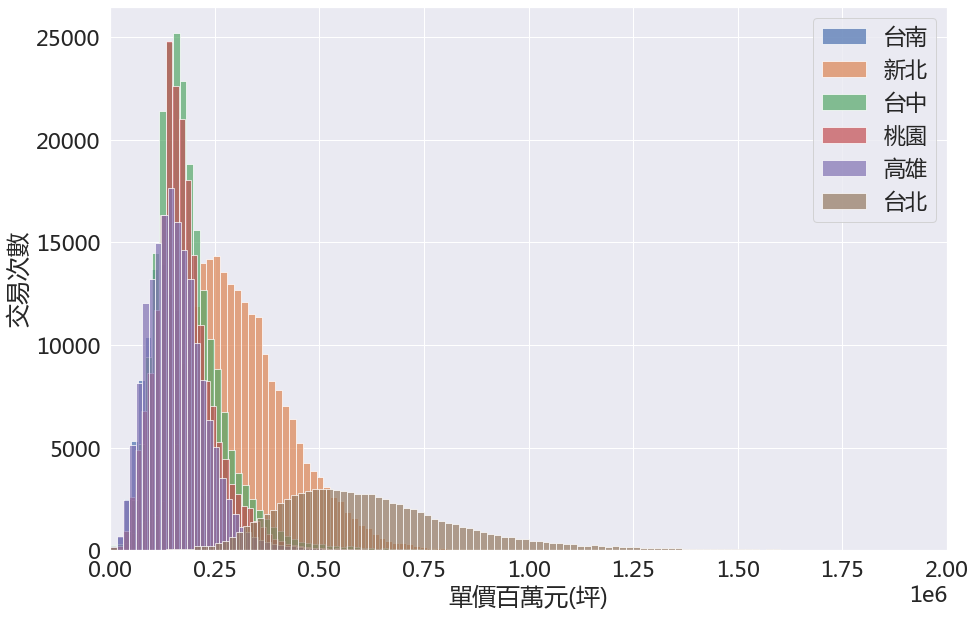

In [36]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
plt.figure(figsize=(15, 10))
plt.legend(fontsize=30, loc='upper right')
for district in set(df['縣市群組']):
    dfdistrict = df[df['縣市群組'] == district]
    dfdistrict['單價元坪'][dfdistrict['單價元坪'] < 2000000].hist(bins=120, alpha=0.7)

plt.xlim(0, 2000000)
plt.xlabel('單價百萬元(坪)')
plt.ylabel("交易次數")
plt.legend(set(df['縣市群組']))
plt.savefig('D:\20201209_3.PNG')

### 檢視六都房價離群的狀況(台北市的離群最大)

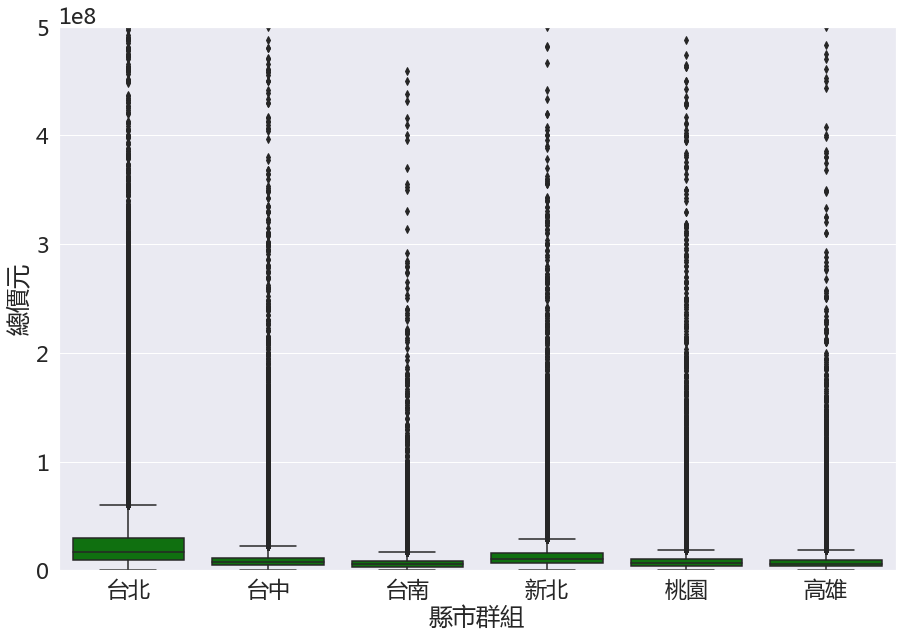

In [35]:
#盒鬚圖
plt.figure(figsize=(15, 10))
sns.set(font_scale=2)
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'  #用來正常顯示中文標籤，微軟雅黑體，['SimHei']
plt.rcParams['axes.unicode_minus'] = False #解決座標軸負數的負號顯示問題
plt.ylim([0,500000000]) 
sns.boxplot(x='縣市群組',y='總價元',data=df,color='green')
plt.savefig('D:\20201209_4.PNG')

In [25]:
#單獨檢視台北的資料
df_tp=df.loc[df['縣市群組']=='台北']

### 檢視台北市各區的房價分布

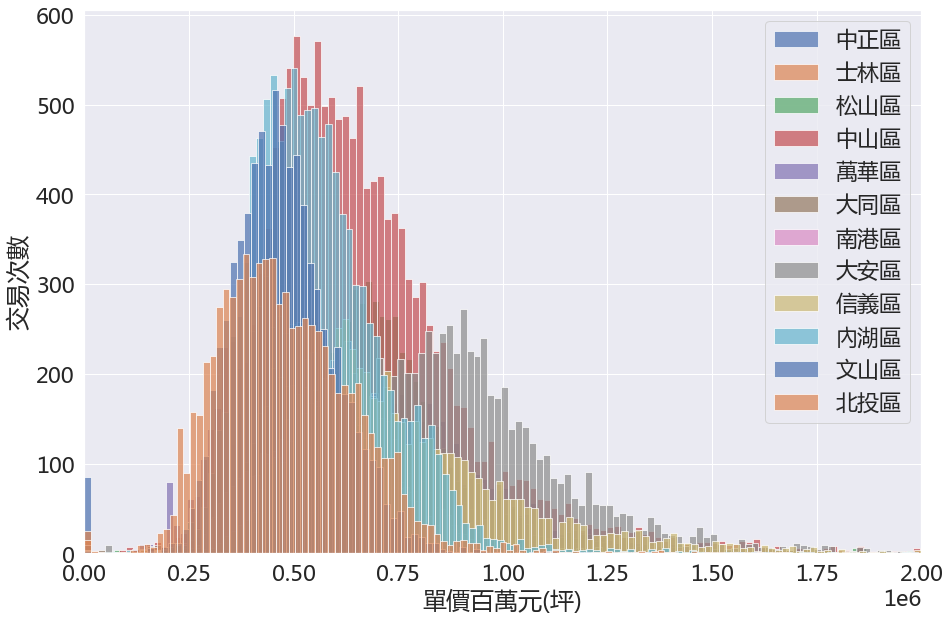

In [37]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
plt.figure(figsize=(15, 10))
plt.legend(fontsize=30, loc='upper right')
for district in set(df_tp['鄉鎮市區']):
    dfdistrict = df_tp[df_tp['鄉鎮市區'] == district]
    dfdistrict['單價元坪'][dfdistrict['單價元坪'] < 2000000].hist(bins=120, alpha=0.7)

plt.xlim(0, 2000000)
plt.xlabel('單價百萬元(坪)')
plt.ylabel("交易次數")
plt.legend(set(df_tp['鄉鎮市區']))
plt.savefig('D:\20201209_5.PNG')

In [23]:
#檢視信義區的資料
df[df['鄉鎮市區']=='信義區'].head(10).sort_values(by='單價元坪')

,Q,主要建材,主要用途,交易年月日,交易標的,交易筆棟數,備註,單價元平方公尺,土地區段位置建物區段門牌,土地移轉總面積平方公尺,建物型態,建物現況格局-廳,建物現況格局-房,建物現況格局-衛,建物現況格局-隔間,建物移轉總面積平方公尺,建築完成年月,有無管理組織,移轉層次,編號,總價元,總樓層數,車位移轉總面積平方公尺,車位總價元,車位類別,都市土地使用分區,鄉鎮市區,非都市土地使用分區,非都市土地使用編定,year,單價元坪,建物型態2,縣市別,縣市群組
交易年月日,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-08-04,4,鋼筋混凝土造,住家用,1010804,房地(土地+建物),土地1建物1車位0,NaN,112016.000,台北市信義區吳興街600巷121~150號,24.16,公寓(5樓含以下無電梯),1,2,2,有,98.2,0780516,無,四層,RPVNMLNLQHHFFDA08CA,11000000.000,五層,0.0,0,NaN,住,信義區,NaN,NaN,2012,370301.373,公寓,台北市,台北
2012-06-29,4,鋼筋混凝土造,住家用,1010629,房地(土地+建物),土地1建物1車位0,NaN,138482.000,台北市信義區景雲街1~30號,29.01,華廈(10層含以下有電梯),2,2,2,有,98.92999999999999,0700416,有,四層,RPWOMLOKQHHFFDA28CA,13700000.000,七層,0.0,0,NaN,住,信義區,NaN,NaN,2012,457792.411,華廈,台北市,台北
2012-07-25,4,鋼骨鋼筋混凝土造,商業用,1010725,房地(土地+建物)+車位,土地1建物2車位1,NaN,150075.000,台北市信義區忠孝東路五段481~510號,7.83,辦公商業大樓,0,0,0,無,124.47,0820514,有,五層,RPRNMLKLQHHFFDA37CA,18680000.000,十七層,34.04,0,坡道平面,住,信義區,NaN,NaN,2012,496116.434,辦公商業大樓,台北市,台北
2012-06-19,4,鋼筋混凝土造,住家用,1010619,房地(土地+建物),土地6建物1車位0,NaN,163974.000,台北市信義區松山路601~630號,27.26,公寓(5樓含以下無電梯),2,3,1,有,82.33,0630522,無,四層,RPVPMLMLQHHFFDA18CA,13500000.000,四層,0.0,0,NaN,住,信義區,NaN,NaN,2012,542063.609,公寓,台北市,台北
2012-07-20,4,鋼筋混凝土造,住家用,1010720,房地(土地+建物),土地1建物1車位0,NaN,185417.000,台北市信義區崇德街1~30號,8.94,華廈(10層含以下有電梯),1,1,1,有,56.629999999999995,0800124,無,七層,RPTNMLNKQHHFFDA87DA,10500000.000,七層,0.0,0,NaN,住,信義區,NaN,NaN,2012,612949.664,華廈,台北市,台北
2012-07-25,4,鋼筋混凝土造,住家用,1010725,房地(土地+建物),土地4建物1車位0,NaN,195057.000,台北市信義區永吉路31~60號,9.47,住宅大樓(11層含以上有電梯),2,3,2,有,106.02000000000001,0740126,有,十二層,RPWNMLQKQHHFFDA38CA,20680000.000,十二層,0.0,0,NaN,商,信義區,NaN,NaN,2012,644817.480,住宅大樓,台北市,台北
2012-07-06,4,鋼筋混凝土造,見其他登記事項,1010706,房地(土地+建物),土地2建物1車位0,NaN,289344.000,台北市信義區基隆路一段121~150號,3.81,住宅大樓(11層含以上有電梯),1,1,1,有,32.83,0950802,有,四層,RPSNMLSJQHHFFDA18DA,9500000.000,十三層,0.0,0,NaN,商,信義區,NaN,NaN,2012,956510.502,住宅大樓,台北市,台北
2012-07-20,4,鋼筋混凝土造,見其他登記事項,1010720,房地(土地+建物),土地2建物1車位0,NaN,300871.000,台北市信義區基隆路一段121~150號,3.88,住宅大樓(11層含以上有電梯),1,2,1,有,33.57,0950802,無,六層,RPVOMLOKQHHFFDA18CA,10100000.000,十三層,0.0,0,NaN,商,信義區,NaN,NaN,2012,994616.343,住宅大樓,台北市,台北
2012-07-02,4,鋼筋混凝土造,見其他登記事項,1010702,房地(土地+建物),土地3建物1車位0,NaN,345339.000,台北市信義區忠孝東路五段361~390號,5.39,住宅大樓(11層含以上有電梯),1,1,1,有,37.64,0940531,有,八層,RPVNMLKKQHHFFDA77DA,13000000.000,十一層,0.0,0,NaN,商,信義區,NaN,NaN,2012,1141618.213,住宅大樓,台北市,台北


In [28]:
#檢視建物型態筆數
df['建物型態2'].value_counts()

住宅大樓      504791
透天厝       201482
華廈        138458
公寓        106445
套房         54050
其他         29849
店面         17349
辦公商業大樓     12224
廠辦          5654
工廠          3204
農舍          1864
倉庫           173
Name: 建物型態2, dtype: int64

### 檢視六都與台北市的建物型態狀況

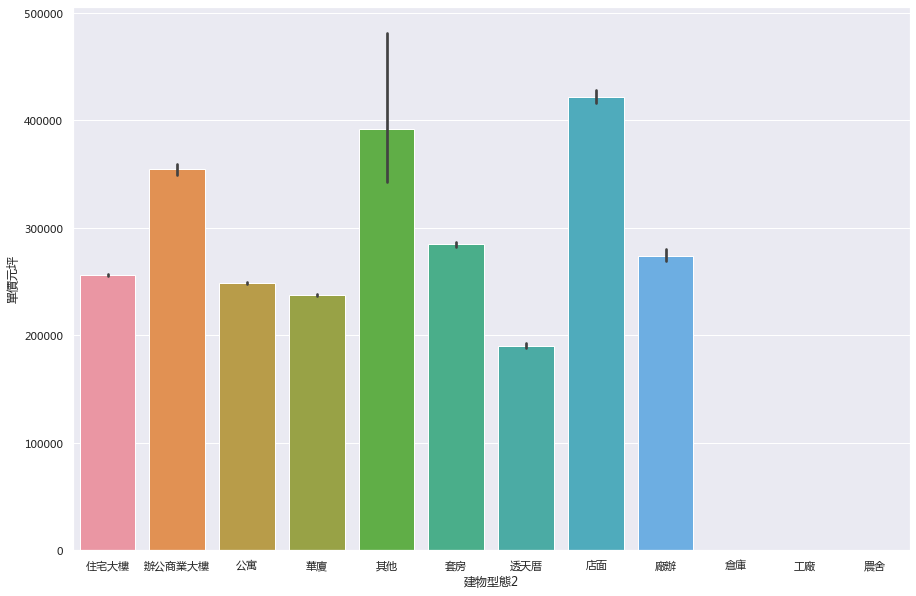

In [38]:
#檢視建物型態狀況(六都)
import seaborn as sns
plt.figure(figsize=(15, 10))
#設置字體大小
sns.set(font_scale=1)
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'  #用來正常顯示中文標籤，微軟雅黑體，['SimHei']
plt.rcParams['axes.unicode_minus'] = False #解決座標軸負數的負號顯示問題
plt.rcParams['font.size'] = 12
sns.barplot(x="建物型態2",
            y="單價元坪",
            data=df           
           )
plt.savefig('D:\20201209_6.PNG')

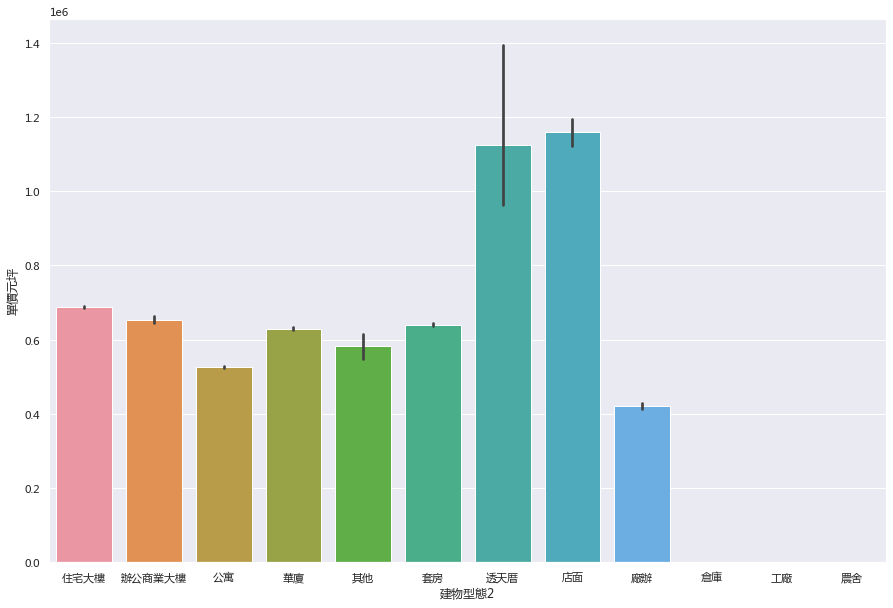

In [39]:
#檢視建物型態狀況(台北市)
import seaborn as sns
plt.figure(figsize=(15, 10))
#設置字體大小
sns.set(font_scale=1)
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'  #用來正常顯示中文標籤，微軟雅黑體，['SimHei']
plt.rcParams['axes.unicode_minus'] = False #解決座標軸負數的負號顯示問題
plt.rcParams['font.size'] = 12
sns.barplot(x="建物型態2",
            y="單價元坪",        
            data=df.loc[df['縣市群組']=='台北']
           )
plt.savefig('D:\20201209_7.PNG')

### 檢視台北市建物型態占比

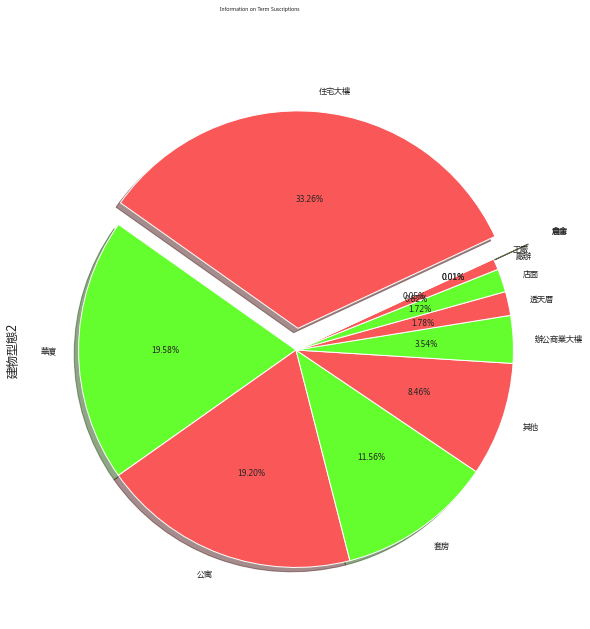

In [40]:
#檢視台北市建物型態占比
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

plt.figure(figsize=(40, 10))
plt.rcParams['font.size'] = 20

colors = ["#FA5858", "#64FE2E"]
labels =df['建物型態2']
plt.suptitle('Information on Term Suscriptions', fontsize=5)
separated = (.1,0,0,0,0,0,0,0,0,0,0.2,0.2)
df["建物型態2"].loc[df['縣市群組']=='台北'].value_counts().plot.pie(explode=separated, autopct='%1.2f%%',shadow=True, colors=colors, 
                                              fontsize=8, startangle=25)
plt.savefig('D:\20201209_8.PNG')